In [43]:
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
import tensorflow as tf

# split data in 80%/10%/10% train/validation/test sets
valid_set_size_percentage = 10 
test_set_size_percentage = 10 

#display parent directory and working directory
print(os.path.dirname(os.getcwd())+':', os.listdir(os.path.dirname(os.getcwd())));
print(os.getcwd()+':', os.listdir(os.getcwd()));

/Users/sibivishtan/Downloads/CIVE stuff: ['.DS_Store', 'Ghule_Kedar.pdf', 'Ass2.pdf', 'Project', 'Ass3.pdf', 'ass4.pdf', 'ass5.pdf', 'ass7.pdf', 'ass6.pdf', 'CIVE.ipynb', '.ipynb_checkpoints']
/Users/sibivishtan/Downloads/CIVE stuff/Project: ['daily_volume_2021.csv', '.DS_Store', 'fundamentals.csv', 'DTW_RNN.ipynb', '.ipynb_checkpoints']


In [56]:
# import all stock prices 
df = pd.read_csv("prices-split-adjusted.csv", index_col = 0)
df.info()
df.head()
# number of different stocks
print('\nnumber of different stocks: ', len(list(set(df.symbol))))
print(list(set(df.symbol))[:10])

<class 'pandas.core.frame.DataFrame'>
Index: 851264 entries, 2016-01-05 to 2016-12-30
Data columns (total 6 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   symbol  851264 non-null  object 
 1   open    851264 non-null  float64
 2   close   851264 non-null  float64
 3   low     851264 non-null  float64
 4   high    851264 non-null  float64
 5   volume  851264 non-null  float64
dtypes: float64(5), object(1)
memory usage: 45.5+ MB

number of different stocks:  501
['PBI', 'EQIX', 'AWK', 'MKC', 'HCN', 'HRB', 'ADI', 'LUK', 'TSO', 'GRMN']


In [57]:
df.describe()

,open,close,low,high,volume
count,851264.000000,851264.000000,851264.000000,851264.000000,8.512640e+05
mean,64.993618,65.011913,64.336541,65.639748,5.415113e+06
std,75.203893,75.201216,74.459518,75.906861,1.249468e+07
min,1.660000,1.590000,1.500000,1.810000,0.000000e+00
25%,31.270000,31.292776,30.940001,31.620001,1.221500e+06
50%,48.459999,48.480000,47.970001,48.959999,2.476250e+06
75%,75.120003,75.139999,74.400002,75.849998,5.222500e+06
max,1584.439941,1578.130005,1549.939941,1600.930054,8.596434e+08


In [58]:
df = df.rename(columns={'Ticker Symbol': 'symbol'})

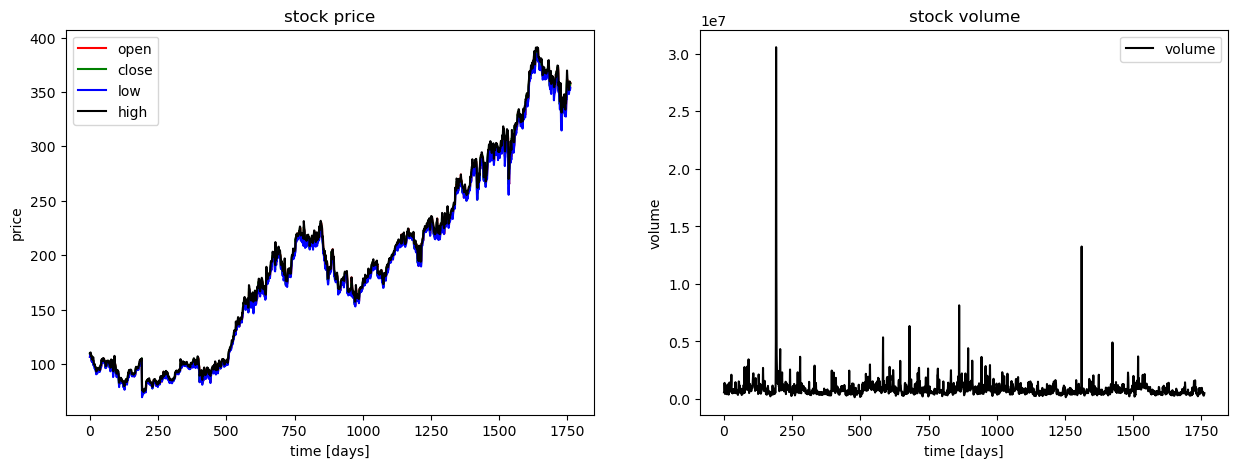

In [59]:
plt.figure(figsize=(15, 5));
plt.subplot(1,2,1);
plt.plot(df[df.symbol == 'EQIX'].open.values, color='red', label='open')
plt.plot(df[df.symbol == 'EQIX'].close.values, color='green', label='close')
plt.plot(df[df.symbol == 'EQIX'].low.values, color='blue', label='low')
plt.plot(df[df.symbol == 'EQIX'].high.values, color='black', label='high')
plt.title('stock price')
plt.xlabel('time [days]')
plt.ylabel('price')
plt.legend(loc='best')
#plt.show()

plt.subplot(1,2,2);
plt.plot(df[df.symbol == 'EQIX'].volume.values, color='black', label='volume')
plt.title('stock volume')
plt.xlabel('time [days]')
plt.ylabel('volume')
plt.legend(loc='best');

In [61]:
# function for min-max normalization of stock
def normalize_data(df):
    min_max_scaler = sklearn.preprocessing.MinMaxScaler()
    df['open'] = min_max_scaler.fit_transform(df.open.values.reshape(-1,1))
    df['high'] = min_max_scaler.fit_transform(df.high.values.reshape(-1,1))
    df['low'] = min_max_scaler.fit_transform(df.low.values.reshape(-1,1))
    df['close'] = min_max_scaler.fit_transform(df['close'].values.reshape(-1,1))
    return df

In [67]:
# function to create train, validation, test data given stock data and sequence length
def load_data(stock, seq_len):
    data_raw = stock.values  # Use .values to convert the DataFrame to a NumPy array
    data = []

    # create all possible sequences of length seq_len
    for index in range(len(data_raw) - seq_len):
        data.append(data_raw[index: index + seq_len])

    data = np.array(data)
    valid_set_size = int(np.round(valid_set_size_percentage / 100 * data.shape[0]))
    test_set_size = int(np.round(test_set_size_percentage / 100 * data.shape[0]))
    train_set_size = data.shape[0] - (valid_set_size + test_set_size)

    x_train = data[:train_set_size, :-1, :]
    y_train = data[:train_set_size, -1, :]

    x_valid = data[train_set_size:train_set_size + valid_set_size, :-1, :]
    y_valid = data[train_set_size:train_set_size + valid_set_size, -1, :]

    x_test = data[train_set_size + valid_set_size:, :-1, :]
    y_test = data[train_set_size + valid_set_size:, -1, :]

    return [x_train, y_train, x_valid, y_valid, x_test, y_test]


In [68]:
# choose one stock
df_stock = df[df.symbol == 'EQIX'].copy()

# Drop the 'symbol' and 'volume' columns
df_stock = df_stock.drop(['symbol'], axis=1)
df_stock = df_stock.drop(['volume'], axis=1)

cols = list(df_stock.columns.values)
print('df_stock.columns.values = ', cols)

df_stock.columns.values =  ['open', 'close', 'low', 'high']


In [69]:
# normalize stock
df_stock_norm = df_stock.copy()
df_stock_norm = normalize_data(df_stock_norm)

# create train, test data
seq_len = 20 # choose sequence length
x_train, y_train, x_valid, y_valid, x_test, y_test = load_data(df_stock_norm, seq_len)
print('x_train.shape = ',x_train.shape)
print('y_train.shape = ', y_train.shape)
print('x_valid.shape = ',x_valid.shape)
print('y_valid.shape = ', y_valid.shape)
print('x_test.shape = ', x_test.shape)
print('y_test.shape = ',y_test.shape)

x_train.shape =  (1394, 19, 4)
y_train.shape =  (1394, 4)
x_valid.shape =  (174, 19, 4)
y_valid.shape =  (174, 4)
x_test.shape =  (174, 19, 4)
y_test.shape =  (174, 4)


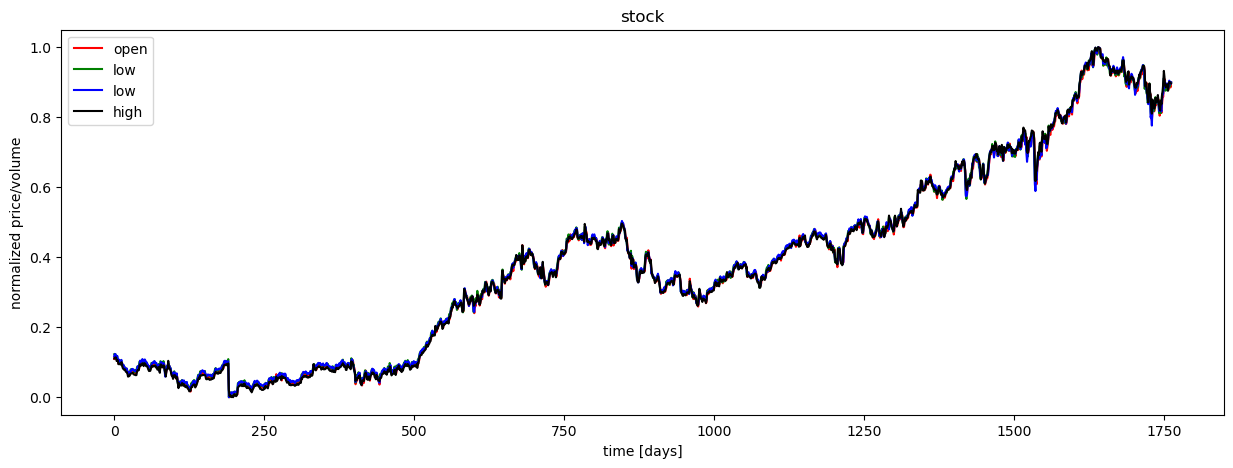

In [70]:
plt.figure(figsize=(15, 5));
plt.plot(df_stock_norm.open.values, color='red', label='open')
plt.plot(df_stock_norm.close.values, color='green', label='low')
plt.plot(df_stock_norm.low.values, color='blue', label='low')
plt.plot(df_stock_norm.high.values, color='black', label='high')
#plt.plot(df_stock_norm.volume.values, color='gray', label='volume')
plt.title('stock')
plt.xlabel('time [days]')
plt.ylabel('normalized price/volume')
plt.legend(loc='best')
plt.show()

In [71]:
index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

In [79]:
## Basic Cell RNN in tensorflow

index_in_epoch = 0;
perm_array  = np.arange(x_train.shape[0])
np.random.shuffle(perm_array)

# function to get the next batch
def get_next_batch(batch_size):
    global index_in_epoch, x_train, perm_array   
    start = index_in_epoch
    index_in_epoch += batch_size
    
    if index_in_epoch > x_train.shape[0]:
        np.random.shuffle(perm_array) # shuffle permutation array
        start = 0 # start next epoch
        index_in_epoch = batch_size
        
    end = index_in_epoch
    return x_train[perm_array[start:end]], y_train[perm_array[start:end]]

# parameters
n_steps = seq_len-1 
n_inputs = 4 
n_neurons = 200 
n_outputs = 4
n_layers = 2
learning_rate = 0.001
batch_size = 50
n_epochs = 100 
train_set_size = x_train.shape[0]
test_set_size = x_test.shape[0]

tf.reset_default_graph()

X = tf.placeholder(tf.float32, [None, n_steps, n_inputs])
y = tf.placeholder(tf.float32, [None, n_outputs])

# use Basic RNN Cell
layers = [tf.contrib.rnn.BasicRNNCell(num_units=n_neurons, activation=tf.nn.elu)
          for layer in range(n_layers)]

# use Basic LSTM Cell 
#layers = [tf.contrib.rnn.BasicLSTMCell(num_units=n_neurons, activation=tf.nn.elu)
#          for layer in range(n_layers)]

# use LSTM Cell with peephole connections
#layers = [tf.contrib.rnn.LSTMCell(num_units=n_neurons, 
#                                  activation=tf.nn.leaky_relu, use_peepholes = True)
#          for layer in range(n_layers)]

# use GRU cell
#layers = [tf.contrib.rnn.GRUCell(num_units=n_neurons, activation=tf.nn.leaky_relu)
#          for layer in range(n_layers)]
                                                                     
multi_layer_cell = tf.contrib.rnn.MultiRNNCell(layers)
rnn_outputs, states = tf.nn.dynamic_rnn(multi_layer_cell, X, dtype=tf.float32)

stacked_rnn_outputs = tf.reshape(rnn_outputs, [-1, n_neurons]) 
stacked_outputs = tf.layers.dense(stacked_rnn_outputs, n_outputs)
outputs = tf.reshape(stacked_outputs, [-1, n_steps, n_outputs])
outputs = outputs[:,n_steps-1,:] # keep only last output of sequence
                                              
loss = tf.reduce_mean(tf.square(outputs - y)) # loss function = mean squared error 
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate) 
training_op = optimizer.minimize(loss)
                                              
# run graph
with tf.Session() as sess: 
    sess.run(tf.global_variables_initializer())
    for iteration in range(int(n_epochs*train_set_size/batch_size)):
        x_batch, y_batch = get_next_batch(batch_size) # fetch the next training batch 
        sess.run(training_op, feed_dict={X: x_batch, y: y_batch}) 
        if iteration % int(5*train_set_size/batch_size) == 0:
            mse_train = loss.eval(feed_dict={X: x_train, y: y_train}) 
            mse_valid = loss.eval(feed_dict={X: x_valid, y: y_valid}) 
            print('%.2f epochs: MSE train/valid = %.6f/%.6f'%(
                iteration*batch_size/train_set_size, mse_train, mse_valid))

    y_train_pred = sess.run(outputs, feed_dict={X: x_train})
    y_valid_pred = sess.run(outputs, feed_dict={X: x_valid})
    y_test_pred = sess.run(outputs, feed_dict={X: x_test})
    

AttributeError: module 'tensorflow' has no attribute 'reset_default_graph'

In [39]:
# Learning rate schedule for the legacy Adam optimizer
initial_learning_rate = 0.01
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=10000, decay_rate=0.9
)
optimizer = Adam(learning_rate=lr_schedule)

In [40]:
# Compile the model with the custom optimizer
model.compile(optimizer=optimizer, loss='mean_squared_error')

In [41]:
# Train the model on your segmented data
model.fit(X_train, y_train, epochs=50, batch_size=32)

Epoch 1/50
662/662 [==============================] - 2s 2ms/step - loss: 449116384.0000
Epoch 2/50
662/662 [==============================] - 1s 2ms/step - loss: 450076224.0000
Epoch 3/50
662/662 [==============================] - 1s 2ms/step - loss: 449783872.0000
Epoch 4/50
662/662 [==============================] - 1s 2ms/step - loss: 449100512.0000
Epoch 5/50
662/662 [==============================] - 1s 2ms/step - loss: 449032128.0000
Epoch 6/50
662/662 [==============================] - 1s 2ms/step - loss: 448914976.0000
Epoch 7/50
662/662 [==============================] - 1s 2ms/step - loss: 448708544.0000
Epoch 8/50
662/662 [==============================] - 1s 2ms/step - loss: 448016000.0000
Epoch 9/50
662/662 [==============================] - 1s 2ms/step - loss: 447066528.0000
Epoch 10/50
662/662 [==============================] - 1s 2ms/step - loss: 446684320.0000
Epoch 11/50
662/662 [==============================] - 1s 2ms/step - loss: 446726464.0000
Epoch 12/50
662/662

In [42]:
# Evaluate the model on the test data
loss = model.evaluate(X_test, y_test)
print("Test Loss:", loss)

166/166 [==============================] - 0s 692us/step - loss: 1589568256.0000
Test Loss: 1589568256.0


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.spatial.distance import euclidean
from fastdtw import fastdtw
import yfinance as yf

[*********************100%%**********************]  1 of 1 completed


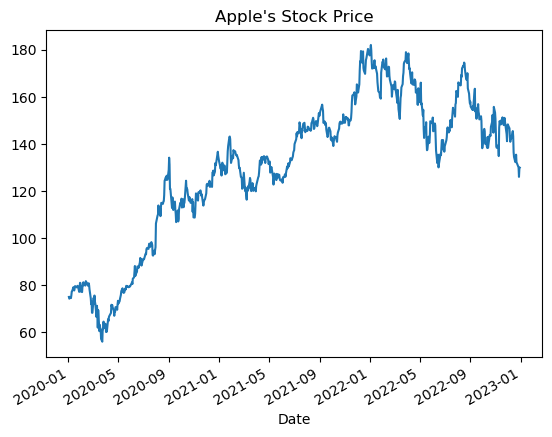

In [3]:
apple_stock = yf.download('AAPL', start='2020-01-01', end='2023-01-01')
apple_stock['Close'].plot(title="Apple's Stock Price")
plt.show()

In [4]:
from fastdtw import fastdtw

# Segmenting the data
part1 = apple_stock['Close'][:125].values
part2 = apple_stock['Close'][125:].values

distance, path = fastdtw(part1, part2, dist=euclidean)
print('Distance:', distance)

# Plotting the data
plt.plot(part1, label='Part 1')
plt.plot(part2, label='Part 2')
plt.title('Stock Price Movement with DTW')
plt.legend()
plt.show()

ValueError: Input vector should be 1-D.

In [5]:
import numpy as np

def z_scale(ts: np.array) -> np.array:
    return (ts - np.mean(ts))/np.std(ts)

def get_dtw_score(ts1: np.array, ts2: np.array) -> np.array:
    
    # Initialise a full cost matrix, filled with np.inf. This is so we can
    # start the algorithm and not get stuck on the boundary
    C = np.full(
        shape = (ts1.shape[0] + 1, ts2.shape[0] + 1), 
        fill_value = np.inf,
    )
    
    # Place the corner to zero, so that we don't have the minimum of 3 infs
    C[0, 0] = 0
    
    for i in range(1, ts1.shape[0] + 1):
        for j in range(1, ts2.shape[0] + 1):
            
            # Euclidian distance between the two points
            dist = abs(ts1[i-1] - ts2[j-1])
            
            # Find the cheapest cost of all three neighbours
            prev_min = min(C[i-1, j], C[i, j-1], C[i-1, j-1])
            
            # Populate the entry in the cost matrix
            C[i, j] = dist + prev_min
            
    return C[-1, -1]

In [6]:
from itertools import combinations

tickers = [
    'SPY', 'QQQ', 'MSFT', 'AMZN', 'GOOGL', 'NVDA', 'TSLA', 'XOM', 'UNH',
]

pairs = [*combinations(tickers, 2)]

/Users/sibivishtan/anaconda3/envs/cive_env/lib/python3.11/site-packages/plotly/graph_objs/_deprecations.py:378: DeprecationWarning:

plotly.graph_objs.Line is deprecated.
Please replace it with one of the following more specific types
  - plotly.graph_objs.scatter.Line
  - plotly.graph_objs.layout.shape.Line
  - etc.




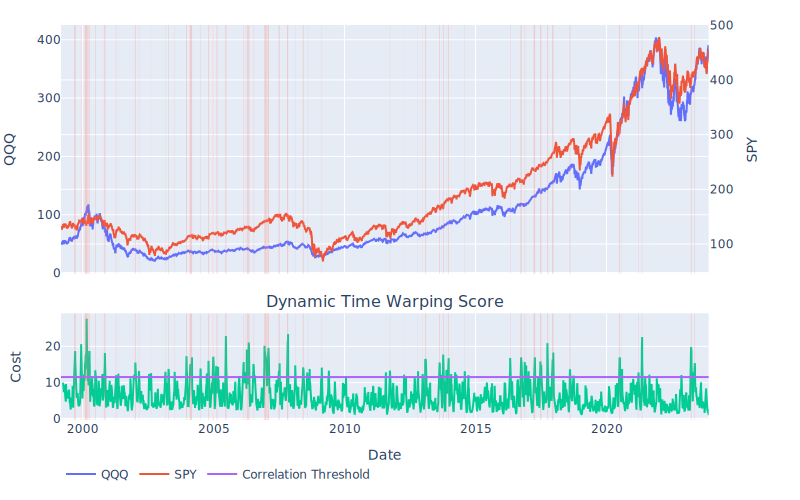

In [1]:
import os
import numpy as np
import numba as nb
import pandas as pd
import yfinance as yf

import plotly.graph_objects as go
from plotly.subplots import make_subplots
import plotly.io as pio
pio.renderers.default='svg'

TS_LENGTH = 20 # How long the dynamic time-warping comparison is
COL_TO_COMPARE = 'Close' # Can be 'Open', 'Low', 'High' or 'Close'
TICKERS = ['QQQ', 'SPY'] # Must be a legnth 2 list
PLOT_FROM = '01-01-01' # Where to plot the comparison from

DTW_THRESHOLD = 11.53


@nb.jit(nopython = True)
def get_dtw_score(ts1: np.array, ts2: np.array) -> np.array:
    '''
    Calculate the dynamic time warping cost between two time series
    '''
    
    # Initialise a full cost matrix, filled with np.inf. This is so we can
    # start the algorithm and not get stuck on the boundary
    C = np.full(
        shape = (ts1.shape[0] + 1, ts2.shape[0] + 1), 
        fill_value = np.inf,
    )
    
    # Place the corner to zero, so that we don't have the minimum of 3 infs
    C[0, 0] = 0
    
    for i in range(1, ts1.shape[0] + 1):
        for j in range(1, ts2.shape[0] + 1):
            
            # Euclidian distance between the two points
            dist = abs(ts1[i-1] - ts2[j-1])
            
            # Find the cheapest cost of all three neighbours
            prev_min = min(C[i-1, j], C[i, j-1], C[i-1, j-1])
            
            # Populate the entry in the cost matrix
            C[i, j] = dist + prev_min
            
    return C[-1, -1]


@nb.jit(nopython = True)
def z_scale(ts: np.array) -> np.array:
    return (ts - np.mean(ts))/np.std(ts)


def load_df(ticker: str):
    '''
    Load in the price df and rename the the price col ready for comparison.
    '''
    return (
        pd.read_csv(f'data/{ticker}.csv')
        [['Date', COL_TO_COMPARE]]
        .rename(
            columns={COL_TO_COMPARE: f'{COL_TO_COMPARE}_{ticker}'}
        )
    )


@nb.jit(nopython = True)
def rolling_score(ts1: np.array, ts2: np.array, length: int) -> np.array:
    '''
    Calculate the dynamic time warping cost over all dates possible.
    '''
    
    scores = np.full(ts1.shape, np.nan)
    
    for n in range(length, ts1.shape[0]):
        
        scores[n] = get_dtw_score(
            ts1=z_scale(ts1[n-length:n]),
            ts2=z_scale(ts2[n-length:n]),
        )
        
    return scores

if __name__ == '__main__':
    
    # Create an empty data folder, if it doesn't exist
    if not os.path.isdir('data'):
        os.mkdir('data')
    
    # Download the data from yahoo finance, if the data-file doesn't exist,
    # otherwise load in the data and store in the data dictionary
    data = {}
    for ticker in TICKERS:
        file = f'data/{ticker}.csv'
        
        if not os.path.isfile(file):
            yf.download(ticker).to_csv(file)
            
        data[ticker] = load_df(ticker)

    # Bring both time series into a single dataframe for comparison
    df = pd.merge(
        data[TICKERS[0]],
        data[TICKERS[1]],
        on='Date',
        how='left',
    )
    
    # Drop any null values to make sure we compare dates where there is data
    # present in both time-series
    df = df.dropna().reset_index(drop=True)
    
    df['DTW_score'] = rolling_score(
        df[f'{COL_TO_COMPARE}_{TICKERS[0]}'].values.astype(np.float64),
        df[f'{COL_TO_COMPARE}_{TICKERS[1]}'].values.astype(np.float64),
        TS_LENGTH,
    )
    
    # Find the entries where the score is above/below the threshold
    df['threshold_breached'] = df['DTW_score'] > DTW_THRESHOLD
    
    df = df[df['Date'] > PLOT_FROM]
    
    # Create the figure
    fig = go.Figure()
    
    fig = make_subplots(
        rows = 2,
        cols = 1,
        shared_xaxes = True,
        vertical_spacing = 0.1,
        subplot_titles = ('', 'Dynamic Time Warping Score'),
        row_width = [0.3, 0.7],
        specs = [[{"secondary_y": True}], [{'secondary_y': False}]]
    )
    
    plot_secondary = {TICKERS[0]: False, TICKERS[1]: True}
    
    for ticker in TICKERS:
        
        col = f'{COL_TO_COMPARE}_{ticker}'
        
        fig.add_trace(
            go.Line(
                x=df['Date'],
                y=df[col],
                name=ticker,
            ),
            row = 1, col = 1, secondary_y=plot_secondary[ticker],
        )
        
    fig.add_trace(
        go.Line(
            x=df['Date'],
            y=df['DTW_score'],
            showlegend=False,
        ),
        row = 2, col = 1,
    )
    
    fig.add_trace(
        go.Line(
            x = df['Date'],
            y = DTW_THRESHOLD*np.ones((len(df))),
            name = 'Correlation Threshold',
        ),
        row = 2, col = 1,
    )
    
    
    df_trend = (
        df[df['threshold_breached']]
        .groupby((~df['threshold_breached']).cumsum())
        ['Date']
        .agg(['first', 'last'])
    )
        
    for idx, row in df_trend.iterrows():
        fig.add_vrect(
            x0 = row['first'], 
            x1 = row['last'],
            line_width = 0,
            fillcolor = 'salmon',
            opacity = 0.3,
        )
    
    fig.update_layout(
        yaxis1 = {'title': TICKERS[0]},
        yaxis2 = {'title': TICKERS[1]},
        yaxis3 = {'title': 'Cost'},
        xaxis2 = {'title': 'Date'},
        legend = {'x': 0, 'y': -0.1, 'orientation': 'h'},
        margin = {'l': 50, 'r': 50, 'b': 50, 't': 25},
        width = 800,
        height = 500,
    )
    
    fig.show()